In [1]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
# mpl.rcParams['axes.unicode_minus']=False # in case minus sign is shown as box
#
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from scipy.optimize import curve_fit
# from scipy import asarray as ar,exp
from numpy import exp
# import uncertainties

In [2]:
# Define gaussian distribution in 2D
# def gaussFunction(x, A, x0, y0, sigma_x, sigma_y, B):
#     return A*np.exp(-((x[0]-x0)**2/(2*sigma_x**2))-((x[1]-y0)**2/(2*sigma_y**2))) + B
from numpy import sqrt, pi

def gaussian(x, area, mean, sigma):
    return area * 1. / sqrt(2*pi * sigma**2) * exp(- (x - mean)**2 / 2 / sigma**2 )

def gaussian_2d(x, area, x0, y0, sigma_x, sigma_y, B=0):
    return area * gaussian(x[0], 1, x0, sigma_x) * gaussian(x[1], 1, y0, sigma_y) + B 

def fit_2x2(x, area, x0, y0, sigma_x, sigma_y, area_b, sigma_b_x,sigma_b_y, B):
    return gaussian_2d(x, area, x0, y0, sigma_x, sigma_y) + \
    gaussian_2d(x, area_b, x0, y0, sigma_b_x, sigma_b_y) + B


def gaussFunction(x, A, x0, y0, sigma_x, sigma_y, B):
    return A*np.exp(-((x[0]-x0)**2/(2*sigma_x**2))-((x[1]-y0)**2/(2*sigma_y**2))) + B

In [3]:
# def CrossSection(mu):
#     # Filter database
#     step_sym = mu[mu.scan == 1][mu.subscan == "2D"]
    
#     # Set delta columns
#     step_sym["delta_x"] = step_sym["x2.set"] - step_sym["x1.set"]
#     step_sym["delta_y"] = step_sym["y2.set"] - step_sym["y1.set"]
    
#     data = np.array([step_sym["delta_x"], step_sym["delta_y"]])
    
#     # Fit 2D distribution
#     fit = {}
#     fit['data'], fit['data.err'] = curve_fit(
#         double_gaussian, 
#         data, 
#         step_sym['mu.inst.sp'].values,
#         p0 = [1, -0.000180, -0.00490, -0.160, 0.150,1],
#         sigma = step_sym['mu.inst.sp.err'].values
#     )
# #     fit['data'], fit['data.err'] = curve_fit(
# #         fit_2x2, 
# #         data, 
# #         step_sym['mu.inst.sp'].values,
# #         p0 = [1, -0.000180, -0.00490, 0.160, 0.150, 1, 3,3, 1],
# #         sigma = step_sym['mu.inst.sp.err'].values
# #     )
    
#     # Get parameters errors from convolution matrix
#     fit['data.err'] = np.sqrt(np.diag(fit['data.err']))
    
#     # Get sigma values
# #     sigma = fit["data"][0] * 2 * np.pi * np.sqrt(fit["data"][3]**2 *  fit["data"][4]**2)
#     sigma = fit["data"][0] 
#     sigma_err = sigma * step_sym['mu.inst.sp.err'].sum() / step_sym['mu.inst.sp'].sum()
    
#     return sigma, sigma_err, fit


In [4]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

def CrossSection(mu):
    # Separate dataframes for x and y 
#     step_sym_x = mu[mu.scan == scan][mu.counter == counter][mu.bxid == bxid][mu.subscan == "Symmetric_X"]
#     step_sym_y = mu[mu.scan == scan][mu.counter == counter][mu.bxid == bxid][mu.subscan == "Symmetric_Y"]

    step_sym = mu[mu.scan == 1][mu.subscan == "2D"]
    
    # Set delta columns
    step_sym["delta_x"] = step_sym["x2.set"] - step_sym["x1.set"]
    step_sym["delta_y"] = step_sym["y2.set"] - step_sym["y1.set"]
    
    data = np.array([step_sym["delta_x"], step_sym["delta_y"]])
    
    # # Fit 2D distribution
    # fit = {}
    # fit['data'], fit['data.err'] = curve_fit(
    #     double_gaussian, 
    #     data, 
    #     step_sym['mu.inst.sp'].values,
    #     p0 = [1, -0.000180, -0.00490, -0.160, 0.150,1],
    #     sigma = step_sym['mu.inst.sp.err'].values
    # )
    
    ##################
    least_squares = LeastSquares(
        data, 
        step_sym['mu.inst.sp'].values,
        step_sym['mu.inst.sp.err'].values,   
        gaussian_2d)

    m = Minuit(least_squares,
    area = 1., 
    x0 = -0.000180,
    y0 = -0.00490,
    sigma_x= 0.160,
    sigma_y=0.150,
    B=1)  # starting values for α and β
    
    m.limits = [(0, None), (-1, 1), (-1, 1), (0.01, 1), (0.01, 1), (0.0, None)]
    ######################

    ######################
    # least_squares = LeastSquares(
    #     data, 
    #     step_sym['mu.inst.sp'].values,
    #     step_sym['mu.inst.sp.err'].values,   
    #     fit_2x2)
    
    # # def fit_2x2(x, area, x0, y0, sigma_x, sigma_y, area_b, sigma_b_x,sigma_b_y, B):

    # m = Minuit(least_squares,
    # area = 1., 
    # x0 = -0.000180,
    # y0 = -0.00490,
    # sigma_x= 0.438,
    # sigma_y=0.291,
    # area_b=1,
    # sigma_b_x= 0.5,
    # sigma_b_y=0.,
    # B=1)  # starting values for α and β
    
    # m.limits = [(0, None), (-0.01, 0.01), (-0.01, 0.01), 
    # (0.400, 0.500), (0.200, 0.350),
    # (0, 1),(0.1, 0.4), (0.05, 0.2),
    # (0.0, None)]
    ######################


    m.migrad()  # finds minimum of least_squares function
    m.hesse()   # accurately computes uncertainties

    fit = {}
    fit['data'], fit['data.err'] = m.values, m.errors
    print(fit['data'], fit['data.err'])

    ################
   
    # Get parameters errors from convolution matrix
    fit['data.err'] = np.sqrt(np.diag(fit['data.err']))
    
    # Get sigma values
#     sigma = fit["data"][0] * 2 * np.pi * np.sqrt(fit["data"][3]**2 *  fit["data"][4]**2)
    sigma = fit["data"][0] 
    sigma_err = sigma * step_sym['mu.inst.sp.err'].sum() / step_sym['mu.inst.sp'].sum()
    
    return sigma, sigma_err, fit



In [5]:
def plot(mu, fit):
    # Filter database 
    step_sym = mu[mu.scan == 1][mu.subscan == "2D"]
    
    # Set delta columns
    step_sym["delta_x"] = step_sym["x2.set"] - step_sym["x1.set"]
    step_sym["delta_y"] = step_sym["y2.set"] - step_sym["y1.set"]
    
    data = np.array([step_sym["delta_x"], step_sym["delta_y"]])
    
    X, Y = np.meshgrid(np.arange(-1.5,1.5,0.01), np.arange(-1.5,1.5,0.01))
    
    # Plot 2D distribution
    fig = plt.figure(figsize=(14, 14))
    # fig.set_size_inches(3*6, 6)
    mu = fig.add_subplot(111, projection='3d')
    mu.get_proj = lambda: np.dot(Axes3D.get_proj(mu), np.diag([1, 1, 1, 1]))

    mu.scatter3D(
        step_sym['delta_x'].values, 
        step_sym['delta_y'].values, 
        step_sym['mu.inst.sp'].values, 
        color='blue',
        label = r'data',
    )
    
    mu.plot_wireframe(
        X, 
        Y, 
        # fit_2x2(
        gaussian_2d(
            [X, Y],
            *fit['data']
        ),
#         fit_2x2(
#             [X, Y],
#             *fit['data']
#         ),
        color='orange',
        label="2D gaussian fit"
        # label = f'fit\n area = {fit["data"][0]} \u00B1 {fit["data.err"][0][0]} \n' + \
        #         f'mean_x = {fit["data"][1]} \u00B1 {fit["data.err"][1][1]} \n' + \
        #         f'sigma_x = {fit["data"][3]} \u00B1 {fit["data.err"][3][3]} \n' + \
        #         f'mean_y = {fit["data"][2]} \u00B1 {fit["data.err"][2][2]} \n' + \
        #         f'sigma_y = {fit["data"][4]} \u00B1 {fit["data.err"][4][4]}'
    )
    # mu.set_xlabel('\u0394 X [mm]')
    # mu.set_ylabel('\u0394 Y [mm]')
    # mu.set_zlabel('\u03BC specific')

    mu.set_xlabel(r'$\Delta x$ [mm]', ha='right', labelpad=30)
    mu.set_ylabel(r'$\Delta y$ [mm]', ha='right',labelpad=30)
    # mu.set_zlabel('\u03BC specific', ha='right', labelpad=25)
    mu.zaxis.set_rotate_label(False)
    mu.set_zlabel(r'$\mathrm{\mu\, /\, \langle n_1n_2\rangle }$ $\left[10^{25}\right]$', ha='right', labelpad=30, rotation=90)

    # plt.ylabel('\u03BC / <N1*N2> * 10^25', ha='right', y=1)
    # mu.dist = 5
    mu.xaxis._axinfo['label']['space_factor'] = 10
    plt.legend(loc=4, bbox_to_anchor=(0.9,0.755))
    mu.minorticks_on()
    # mu.text((0, 0,0), "LHCb Preliminary", {'size': 28})
    mu.view_init(elev=20., azim=27)

    mu.text2D(0.15, 0.8, "LHCb Preliminary", 
        transform=mu.transAxes, fontdict={'size': 28})

#     mu.set_title(f'lc - {counter}, bxid {bxid}')
    # plt.legend()

    plt.savefig(f'Plots/2D/online.pdf')
    plt.show
#     plt.close(fig)


In [6]:
# Read CSV file
fill = 7703
run = 232824
mu = pd.read_csv(f'Data/online_mu.{fill}.gz', index_col=0).dropna()

In [7]:
mu["mu.inst.sp"] = mu.groupby(["x1.set","x2.set","y1.set","y2.set"])["mu.inst.sp"].transform("mean")
mu["mu.inst.sp.err"] = mu.groupby(["x1.set","x2.set","y1.set","y2.set"])["mu.inst.sp.err"].transform("mean")
mu = mu.drop_duplicates(subset=["x1.set","x2.set","y1.set","y2.set"])

<ValueView area=1.2159264616628458 x0=-0.0047803568382428505 y0=-0.06161191547786622 sigma_x=0.44493289645817086 sigma_y=0.29691849535870235 B=0.11175638181876328> <ErrorView area=0.012833788943465207 x0=0.0038045476227415633 y0=0.0023891552153899355 sigma_x=0.0036675266915992544 sigma_y=0.0026472457493093293 B=0.0022580426982476906>


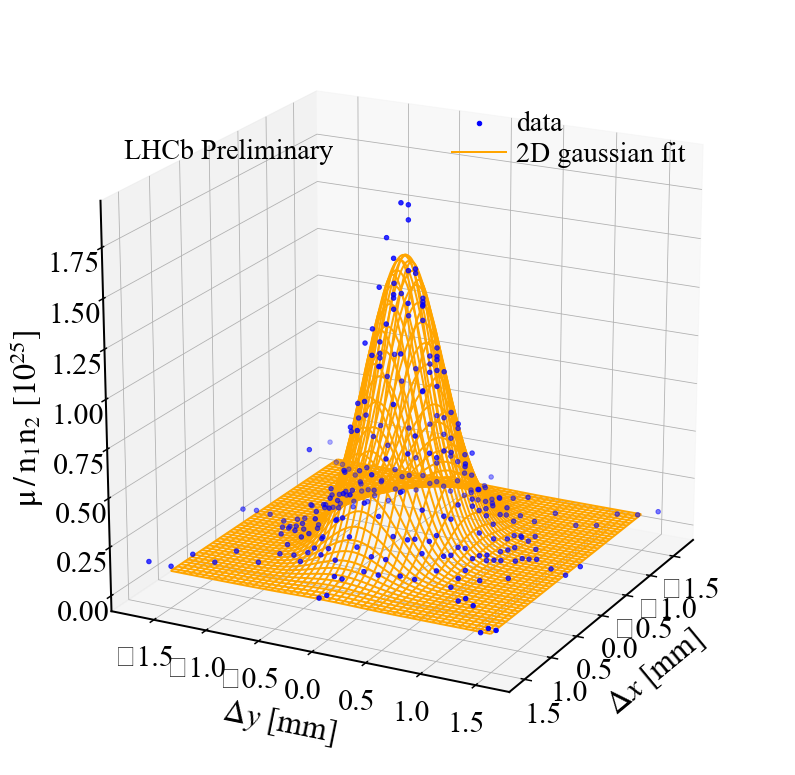

In [8]:
# %matplotlib widget
# %matplotlib inline
# fix, ax = plt.subplots(dpi=500)
xsec_columns = ['xsec', 'xsec.err']
xsec = pd.DataFrame()


sigma, sigma_err, fit = CrossSection(mu)
row = pd.DataFrame([[sigma, sigma_err]], columns=xsec_columns)
xsec = pd.concat([xsec, row], ignore_index=True)
plot(mu, fit)    


In [9]:
fit

{'data': <ValueView area=1.2159264616628458 x0=-0.0047803568382428505 y0=-0.06161191547786622 sigma_x=0.44493289645817086 sigma_y=0.29691849535870235 B=0.11175638181876328>,
 'data.err': array([[0.11328631, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.06168102, 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.04887899, 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.06056011, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.05145139,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.04751887]])}

In [10]:
help(plt.text)

Help on function text in module matplotlib.pyplot:

text(x, y, s, fontdict=None, withdash=False, **kwargs)
    Add text to the axes.
    
    Add the text *s* to the axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : scalars
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dictionary, optional, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by your rc parameters.
    
    withdash : boolean, optional, default: False
        Creates a `~matplotlib.text.TextWithDash` instance instead of a
        `~matplotlib.text.Text` instance.
    
    Returns
    -------
    text : `.Text`
        The created `.Text` instance.
    
    Other Parameters
    ----------------
    **kwargs : `~matplotlib.text

In [11]:
xsec

xsec  xsec.err
0  1.215926  0.100346

In [12]:
mu[mu["mu.inst.sp"] > 1.7][["x1.set","x2.set","y1.set","y2.set"]]

x1.set    x2.set    y1.set    y2.set
180  0.002203 -0.002203  0.027527 -0.027527
770  0.035971 -0.035971  0.027527 -0.027527
850  0.035971 -0.035971  0.027527 -0.027527
910 -0.031565  0.031565  0.027527 -0.027527
980  0.035971 -0.035971  0.027527 -0.027527

In [13]:
mu["mu.inst.sp"] = mu["mu.inst.sp"] - fit["data"][-1]

In [14]:
mu[mu.subscan == "2D"]["mu.inst.sp"].sum()*0.066*0.066

0.3721161051379607

TypeError: 'NoneType' object is not subscriptable

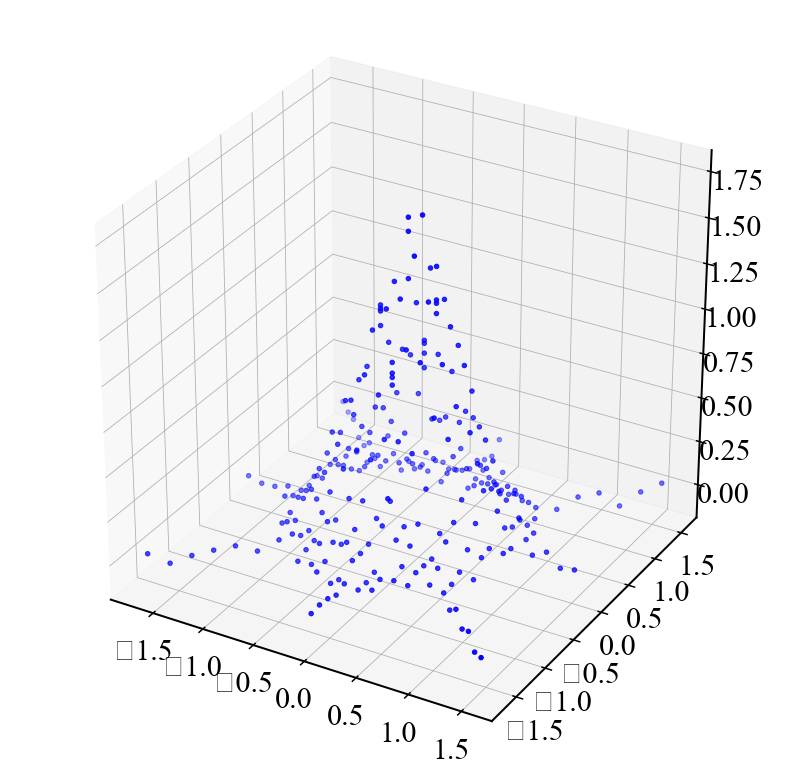

In [15]:
plot(mu, None)    

In [ ]:
xsec.to_csv('xsec_2D.csv')

In [ ]:
xsec_avg = xsec.groupby(['counter']).mean().drop(['bxid','xsec.err'], axis=1).reset_index()
errors = list()
for counter in xsec.counter.unique():
    sq_vals =  np.power(xsec['xsec.err'][xsec['counter']==counter].values, 2)
    errors.append((1/xsec[xsec['counter']==counter].shape[0]) * np.sqrt(sq_vals.sum()))
    
xsec_avg['xsec.err'] = np.array(errors)

In [ ]:
xsec_avg